## Importing the Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import f1_score,accuracy_score,roc_curve,auc
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore",category = FutureWarning)
warnings.filterwarnings("ignore",category= DeprecationWarning)

## Importing the dataset

In [2]:
data = pd.read_csv("sentiment.tsv",sep = "\t")
data.columns = ['label','body_text']
data.head()

,label,body_text
0,pos,having a vodka tonic and looking forward to go...
1,pos,@ddlovatofans1neg1 Could you follow me please....
2,pos,@jordanknight for once.................. PLEAS...
3,neg,Had a dream about a walk in fast food resturau...
4,pos,@TroyBrownBBNews Yes... For a &quot;friend&quot;


In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])
data.head()

,label,body_text
0,1,having a vodka tonic and looking forward to go...
1,1,@ddlovatofans1neg1 Could you follow me please....
2,1,@jordanknight for once.................. PLEAS...
3,0,Had a dream about a walk in fast food resturau...
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;


## Cleaning of Data

In [4]:
def remove_pattern(input_txt,pattern):
    r = re.findall(pattern,input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

## Remove twitter handles (@user)

In [5]:
data['tidy_tweet'] = np.vectorize(remove_pattern)(data['body_text'],"@[\w]*")
data.head()

,label,body_text,tidy_tweet
0,1,having a vodka tonic and looking forward to go...,having a vodka tonic and looking forward to go...
1,1,@ddlovatofans1neg1 Could you follow me please....,Could you follow me please.I would really app...
2,1,@jordanknight for once.................. PLEAS...,for once.................. PLEASE TELL US WHY...
3,0,Had a dream about a walk in fast food resturau...,Had a dream about a walk in fast food resturau...
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;,Yes... For a &quot;friend&quot;


## Remove special characters, numbers, punctuations

In [6]:
data['tidy_tweet'] = data['tidy_tweet'].str.replace("[^a-zA-Z#]"," ")
data.head()

,label,body_text,tidy_tweet
0,1,having a vodka tonic and looking forward to go...,having a vodka tonic and looking forward to go...
1,1,@ddlovatofans1neg1 Could you follow me please....,Could you follow me please I would really app...
2,1,@jordanknight for once.................. PLEAS...,for once PLEASE TELL US WHY...
3,0,Had a dream about a walk in fast food resturau...,Had a dream about a walk in fast food resturau...
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;,Yes For a quot friend quot


## Tokenize the tweets

In [7]:
tokenized_tweet = data['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [having, a, vodka, tonic, and, looking, forwar...
1    [Could, you, follow, me, please, I, would, rea...
2    [for, once, PLEASE, TELL, US, WHY, u, were, th...
3    [Had, a, dream, about, a, walk, in, fast, food...
4                    [Yes, For, a, quot, friend, quot]
Name: tidy_tweet, dtype: object

In [8]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
tokenized_tweet.head()

0    [have, a, vodka, tonic, and, look, forward, to...
1    [could, you, follow, me, pleas, I, would, real...
2    [for, onc, pleas, tell, US, whi, u, were, thin...
3    [had, a, dream, about, a, walk, in, fast, food...
4                     [ye, for, a, quot, friend, quot]
Name: tidy_tweet, dtype: object

## Joining the tokenized word in the same data

In [9]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
data['tidy_tweet'] = tokenized_tweet
data.head()

,label,body_text,tidy_tweet
0,1,having a vodka tonic and looking forward to go...,have a vodka tonic and look forward to go to s...
1,1,@ddlovatofans1neg1 Could you follow me please....,could you follow me pleas I would realli appre...
2,1,@jordanknight for once.................. PLEAS...,for onc pleas tell US whi u were think of thi ...
3,0,Had a dream about a walk in fast food resturau...,had a dream about a walk in fast food resturau...
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;,ye for a quot friend quot


## Adding other column for length of the tweet and punctuation

In [10]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")),3)*100

In [11]:
data['body_len'] = data['body_text'].apply(lambda x:len(x) - x.count(" "))
data['punct%'] = data['body_text'].apply(lambda x:count_punct(x))
data.head()

,label,body_text,tidy_tweet,body_len,punct%
0,1,having a vodka tonic and looking forward to go...,have a vodka tonic and look forward to go to s...,92,1.1
1,1,@ddlovatofans1neg1 Could you follow me please....,could you follow me pleas I would realli appre...,66,4.5
2,1,@jordanknight for once.................. PLEAS...,for onc pleas tell US whi u were think of thi ...,81,27.2
3,0,Had a dream about a walk in fast food resturau...,had a dream about a walk in fast food resturau...,96,1.0
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;,ye for a quot friend quot,44,18.2


## Generating word cloud for data

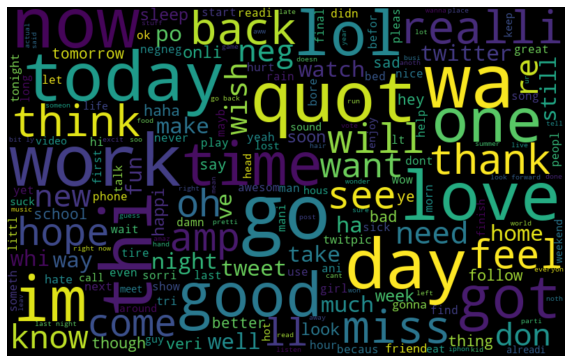

In [12]:
all_words = ' '.join([text for text in data['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height = 500, random_state=21,max_font_size=110).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## Wordcloud for negative tweets

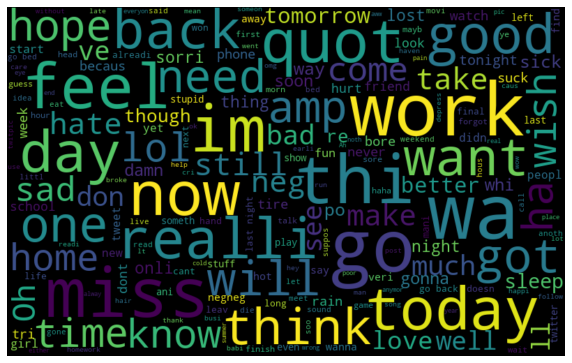

In [13]:
negative_words = ' '.join([text for text in data['tidy_tweet'][data['label']==0]])
wordcloud = WordCloud(width=800, height = 500, random_state=21,max_font_size=110).generate(negative_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [14]:
# function to collect hashtags
def hashtag_extract(x):
    hashtag = []
    # loop over the words
    for i in x:
        ht = re.findall(r"#(\w+)",i)
        hashtag.append(ht)
    return hashtag

In [15]:
# extract hash from no racist/sexist tweets
HT_regular = hashtag_extract(data['tidy_tweet'][data['label']==0])
# positive
HT_negative = hashtag_extract(data['tidy_tweet'][data['label']==1])
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

In [16]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag':list(a.keys()),
                 'count':list(a.values())})
d.head()

,Hashtag,count
0,github,1
1,fb,2
2,stupidgalaev,1
3,nswdet,1
4,bgt,1


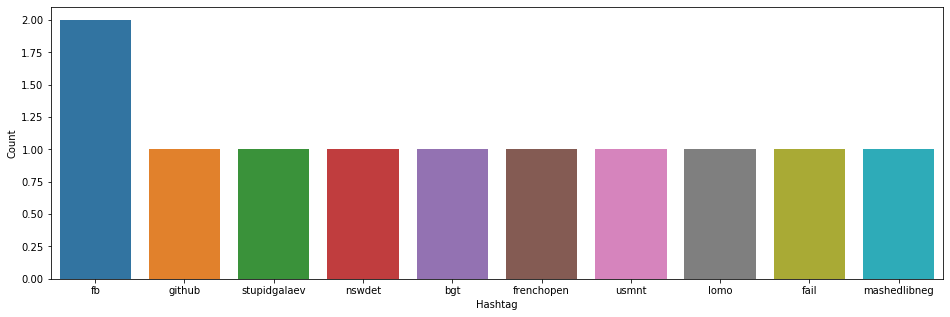

In [17]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag':list(a.keys()),
                 'count':list(a.values())})
d = d.nlargest(columns = "count",n = 10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d,x = 'Hashtag', y = "count")
ax.set(ylabel = 'Count')
plt.show()

## Histogram for Negative tweets

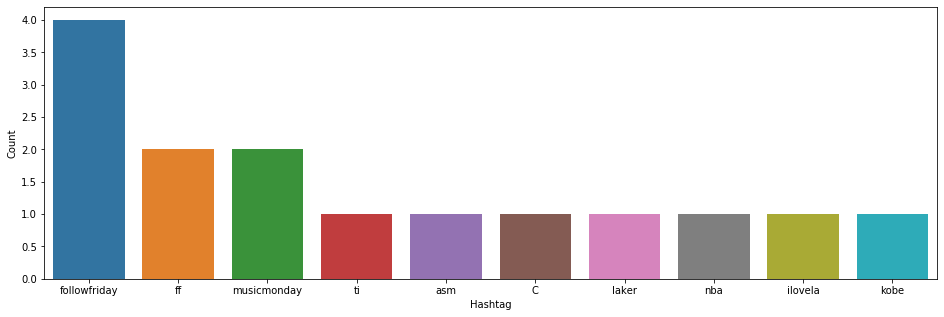

In [18]:
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag':list(a.keys()),
                 'count':list(a.values())})
d = d.nlargest(columns = "count",n = 10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d,x = 'Hashtag', y = "count")
ax.set(ylabel = 'Count')
plt.show()

## Feature selection and Engineering
### 1) Count Vectorizer
### 2) Tfidf Vectoriser

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(stop_words='english')
bow = bow_vectorizer.fit_transform(data['tidy_tweet'])
X_count_feat = pd.concat([data['body_len'],data['punct%'],pd.DataFrame(bow.toarray())],axis = 1)
X_count_feat.head()

,body_len,punct%,0,1,2,3,4,5,6,7,...,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943
0,92,1.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,66,4.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,81,27.2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,96,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,44,18.2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data['tidy_tweet'])
X_tfidf_feat = pd.concat([data['body_len'],data['punct%'],pd.DataFrame(tfidf.toarray())],axis = 1)
X_tfidf_feat.head()

,body_len,punct%,0,1,2,3,4,5,6,7,...,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943
0,92,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,66,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,81,27.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,96,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,44,18.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Testing all classification algorithms

In [21]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [22]:
model = []
model.append(('LR',LogisticRegression()))
model.append(('RF',RandomForestClassifier()))
model.append(('GB',GradientBoostingClassifier()))
model.append(('DT',DecisionTreeClassifier()))
model.append(('NB',GaussianNB()))
model.append(('KNN',KNeighborsClassifier()))
model.append(('SVC',SVC()))

## 10 fold crossvalidation for all the algorithms with X_count_feat data

In [23]:
for mod,clf in model:
    scores = cross_val_score(clf,X_count_feat,data['label'],scoring = 'accuracy',cv = 10)
    print("Model is %s and Score %f"%(mod,scores.mean()))

Model is LR and Score 0.673944
Model is RF and Score 0.648980
Model is GB and Score 0.639470
Model is DT and Score 0.604462
Model is NB and Score 0.596997
Model is KNN and Score 0.501987
Model is SVC and Score 0.488500


## 10 fold crossvalidation for all the algorithms with X_tfidf_feat data

In [24]:
for mod,clf in model:
    scores = cross_val_score(clf,X_tfidf_feat,data['label'],scoring = 'accuracy',cv = 10)
    print("Model is %s and Score %f"%(mod,scores.mean()))

Model is LR and Score 0.679419
Model is RF and Score 0.640025
Model is GB and Score 0.626952
Model is DT and Score 0.570474
Model is NB and Score 0.600967
Model is KNN and Score 0.488995
Model is SVC and Score 0.493005


## 1) Parameter tuning Linear Regression Count Vectorizer

In [25]:
param_grid = {'C':[0.001,0.01,0.1,1,10,100]}
grid = GridSearchCV(LogisticRegression(),param_grid,cv = 10)
grid.fit(X_count_feat,data['label'])

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [26]:
grid.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
Logistic_model = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
scores = cross_val_score(Logistic_model,X_count_feat,data['label'],scoring='accuracy',cv=10)
print("Model is %s and Score %f"%("LR",scores.mean()))

Model is LR and Score 0.689934


## 2) Parameter tuning Linear Regression TfiDf

In [28]:
param_grid = {'C':[0.001,0.01,0.1,1,10,100]}
grid = GridSearchCV(LogisticRegression(),param_grid,cv = 10)
grid.fit(X_tfidf_feat,data['label'])

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [29]:
grid.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
Logistic_model = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
scores = cross_val_score(Logistic_model,X_tfidf_feat,data['label'],scoring='accuracy',cv=10)
print("Model is %s and Score %f"%("LR",scores.mean()))

Model is LR and Score 0.679419


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_count_feat, data['label'], test_size=0.33, random_state=42)

In [32]:
model = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
model.fit(X_train,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
pred = model.predict(X_test)

In [34]:
from sklearn.metrics import confusion_matrix,accuracy_score

In [35]:
accuracy_score(pred,y_test)

0.6803030303030303

In [36]:
confusion_matrix(y_test,pred)

array([[218,  95],
       [116, 231]])